<h1 style="text-align: center; font-family: Verdana; font-size: 32px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; font-variant: small-caps; letter-spacing: 3px; color: #7b4f44; background-color: #ffffff;">VinBigData Chest X-ray Abnormalities Detection</h1>

이 대회는 흉부 엑스레이와 관련된 데이터로, 흉부 이상 14종을 자동으로 찾고 분류합니다. 15000개의 train set과 3000개의 test set으로 구성되어 있습니다. 

# 1. 필요 라이브러리 import & data load

In [1]:
# 필요한 여러 라이브러리 import
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import pydicom
from pydicom import dcmread
from pathlib import Path

In [2]:
# 데이터 읽어오기
df = pd.read_csv("../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
df.head(10)

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   
5  1c32170b4af4ce1a3030eb8167753b06  Pleural thickening        11     R9   
6  0c7a38f293d5f5e4846aa4ca6db4daf1                 ILD         5    R17   
7  47ed17dcb2cbeec15182ed335a8b5a9e         Nodule/Mass         8     R9   
8  d3637a1935a905b3c326af31389cb846  Aortic enlargement         0    R10   
9  afb6230703512afc370f236e8fe98806  Pulmonary fibrosis        13     R9   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN  
5   627.0   357.0   947.0   433.0  
6  1347.0   245.0  2188.0  2169.0  
7   557.0  2352.0   675.0  2484.0  
8  1329.0   743.0  1521.0   958.0  
9  1857.0  1607.0  2126.0  2036.0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


## 1.1: DATA DESCRIPTION

**Columns**
- `image_id` - unique image identifier
- `class_name` - the name of the class of detected object
- `class_id` - the ID of the class of detected object
- `rad_id` - the ID of the radiologist that made the observation
- `x_min` - minimum X coordinate of the object's bounding box
- `y_min` - minimum Y coordinate of the object's bounding box
- `x_max` - maximum X coordinate of the object's bounding box
- `y_max` - maximum Y coordinate of the object's bounding box


**LABELS**
- `0` - Aortic enlargement
- `1` - Atelectasis
- `2` - Calcification
- `3` - Cardiomegaly
- `4` - Consolidation
- `5` - ILD
- `6` - Infiltration
- `7` - Lung Opacity
- `8` - Nodule/Mass
- `9` - Other lesion
- `10` - Pleural effusion
- `11` - Pleural thickening
- `12` - Pneumothorax
- `13` - Pulmonary fibrosis
- `14` - No Findings

<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Aortic enlargement (대동맥 비대)</b>

- 대동맥 비대. 대동맥류의 신호로, 이 상태는 종종 대동맥의 상승에서 발생합니다. 
- 일반적으로 동맥류라는 용어는 축 직경이 상행 대동맥이 5cm 이상이고 하향 대동맥이 4cm 이상일 때 사용됩니다.

<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Atelectasis (무기폐)</b>

- 무기폐는 폐의 일부 또는 전부에 공기가 없고 허탈(?)된 상태입니다. (네이버 사전 : 폐포 내 공기의 양이 적거나 매우 결핍된 폐의 이상상태)
- 일반적인 원인은 기관지 막힘으로, 무기폐에서는 흉부 엑스레이의 밀도가 증가합니다. (일반적으로 더 흰색, 흑백 반전 이미지에서는 검은 색을 띄고 있습니다.)


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Calcification(석회화)</b>

- 석회화는 폐 또는 흉막의 이전 염증이 치유된 부위에 침착될 수 있습니다. 많은 질명이나 상태가 흉부 x레이에서 석화화를 보여줍니다.
- 석회화는 대동맥에서 발생하거나 종격동 림프절에서 발생할 수 있습니다.

<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Cardiomegaly(심장비대)</b>

- 심비대는 일반적으로 심장 너비와 가슴 너비의 비율이 50% 이상일 때 진단됩니다. 이 진단 기준은 이 대회의 필수 기반이 될 수 있습니다.
- 심비대는 고혈압, 관상 동맥 질환, 감염, 유전질환 및 심근 병증을 포함한 많은 상태로 인해 발생할 수 있습니다.
- 심비대 진단을 위한 심폐 비율 기준은 0.5보다 큰 비율입니다. 그러나 이것은 환자가 서있는 동안 엑스레이를 수행한 경우에만 해당됩니다. 환자가 앉아있거나 침대에 있는 경우 이 기준을 사용할 수 없습니다. 환자가 앉아있는지 또는 서있는지를 확인하기 위해 위장에 공기가 있는지 감지합니다. (공기가 없는 경우 환자는 서있지 않음 -> 기준을 사용할 수 없음)



<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Consolidation (경화, 강화)</b>

- 강화는 폐포의 공기 함유 공간을 대체하는 체액, 세포 또는 조직의 침투로 인한 폐 투과성의 감소입니다.
- 공식적으로는 공기 영역 강화라고 합니다.
- 엑스레이 촬영시 공기층의 밀도가 높아지고 폐 혈관은 보이지 않지만 흰색 바탕에 검은 기관지가 보이는데 이를 '공기 기관지 조영술'이라고 합니다. 공기가 기관에 남아있기 때문에 엑스레이를 흡수하지 않고 검은 색으로 보이며 정상적인 사진에서 흑백이 반전됩니다. 


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">ILD (간질성 폐 질환)</b>

- ILD, Interstitial Lung Disease
- 간질성 폐질환은 간질성 공간이 손상되는 많은 상태에 대한 일반족인 용어입니다.
- 틈새 공간은 폐포의 벽과 혈관 및 작은 기도 주변의 공간을 의미합니다.
- 흉부 방사선 촬영 결과에는 지상 유리 불투명도(=흐릿한 불투명 영역), 선형 망상 그림자 및 세밀한 그림자가 포함됩니다. 


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Infiltration (침투)</b>

- 일부 유체 성분이 폐포로 침투하면 발생합니다.
- 강화(Consolidation)과 구별하기 어렵고 어떤 경우네는 구별이 불가능합니다. 자세한 내용은 아래를 참고하세요. 
- <https://allnurses.com/consolidation-vs-infiltrate-vs-opacity-t483538/>


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Lung Opacity (폐 불투명도)</b>

- 폐 불투명도는 많은 잠재석 의미와 해석을 갖는 용어입니다. 자세한 내용인 아래 캐글 디스커션 링크를 참고하세요. 
- <https://www.kaggle.com/zahaviguy/what-are-lung-opacities)>
- 폐 불투명도는 흔히 흉부 방사선 촬영에서 필요한 것보다 흰색인 영역으로 식별할 수 있습니다. 


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Nodule/Mass (결절)</b>

- 결절과 대종(?)은 주로 폐암에서 볼 수 있으며 결장암 및 신장암, 폐균증, 비결핵성 미코박테리아, 구식폐렴 및 양성 종양과 같은 신체의 다른 부분에서 전이됩니다.
- 결절은 흉부 x-ray 이미지에 나타나는 둥근 음영(일반적으로 직경 3cm미만)입니다.


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Other lesion (다른 병변)</b>

- 여기에는 다른 범주에 속하지 않는 모든 이상이 포함됩니다. 뼈 관통 이미지, 골절, 피하 폐기종 등이 포함됩니다.


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Pleural effusion (흉막삼출)</b>

- 흉막삼출은 흉강의 폐 외부에 물이 축적되는 것을 말합니다.
- 폐 바깥쪽은 흉막으로 알려진 두개의 층으로 구성된 얇은 막으로 덮여있습니다. 이 두 층 사이의 체액 축적을 흉막삼출이라고 합니다.
- 흉막 삼출의 결과는 매우 다양하며 방사선 사진을 똑바로 세웠는지 누운 자세로 찍었는지에 따라 다릅니다.
- 흉막 삼출의 가장 흔한 증상은 한쪽 횡경막의 상승, 횡경막 편 평화 또는 늑골과 횡경막 사이의 각도 (일반적으로 30도 이상)입니다.

<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Pleural thickening (늑막 두께)</b>

- 흉막은 폐를 덮는 막이며, 흉막 두깨의 변화를 흉막 비후라고 합니다.
- 종종 폐의 최상부에서 볼 수 있습니다. 


<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Pneumothorax (기흉)</b>

- 기흉은 공기가 폐에서 누출되어 흉강에 축적되는 상태입니다.
- 공기가 새어 가슴에 쌓이면 갈비뼈가 있어 풍선처럼 바깥쪽으로 팽창할 수 있습니다. 대신, 폐는 공기에 의해 밀리고 작아집니다. 즉, 기흉이란 폐에서 공기가 새고 폐가 작아지는 (축소되는) 상황입니다.
- 기흉의 흉부 방사선 사진에서 허탈된 폐는 정상보다 하얗고 폐가 사라진 부위는 균일하게 검은색입니다. 게다가 폐의 가장자리는 선형으로 보일 수 있습니다. 

<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">Pulmonary fibrosis (폐 섬유증)</b>

- 폐 섬유증은 다양한 원인으로 인한 폐 간질의 염증으로 벽이 두꺼워지고 굳어지고, 섬유화 및 흉터가 생깁니다.
- 섬유증 영역은 공기 함량을 잃어 종종 빽빽한 코드 그림자 또는 세분화된 그림자를 생성합니다. 

<br><b style="text-decoration: underline; font-family: Verdana; text-transform: uppercase;">No finding</b>

- X-ray 이미지에 흉부 이상을 찾을 수 없는 상태입니다. 정상 이미지이며, 비정상 이미지와 구별하는 데 필요한 기준 이미지입니다. 

# 2. 데이터 시각화 & 분석

In [4]:
df['rad_id'].unique()

array(['R11', 'R7', 'R10', 'R9', 'R17', 'R3', 'R8', 'R6', 'R5', 'R4',
       'R2', 'R16', 'R1', 'R15', 'R13', 'R12', 'R14'], dtype=object)

In [5]:
df['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [6]:
fig = px.histogram(df, x="class_name", color="class_name")

fig.update_layout(
    yaxis=dict(title_text='Count', titlefont=dict(size=20)),
    xaxis=dict(title_text='Abnormality Label Name', titlefont=dict(size=20)),
    title_text='Abnormalities Count Plot'
)
fig.show()

In [7]:
def percent_distribution(data):
    # Get the count for each label
    label_counts = data.class_name.value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

percent_distribution(df)

No finding                    :   31818 or 46.85%
Aortic enlargement            :   7162 or 10.54%
Cardiomegaly                  :   5427 or 7.99%
Pleural thickening            :   4842 or 7.12%
Pulmonary fibrosis            :   4655 or 6.85%
Nodule/Mass                   :   2580 or 3.79%
Lung Opacity                  :   2483 or 3.65%
Pleural effusion              :   2476 or 3.64%
Other lesion                  :   2203 or 3.24%
Infiltration                  :   1247 or 1.83%
ILD                           :   1000 or 1.47%
Calcification                 :   960 or 1.41%
Consolidation                 :   556 or 0.81%
Atelectasis                   :   279 or 0.41%
Pneumothorax                  :   226 or 0.33%


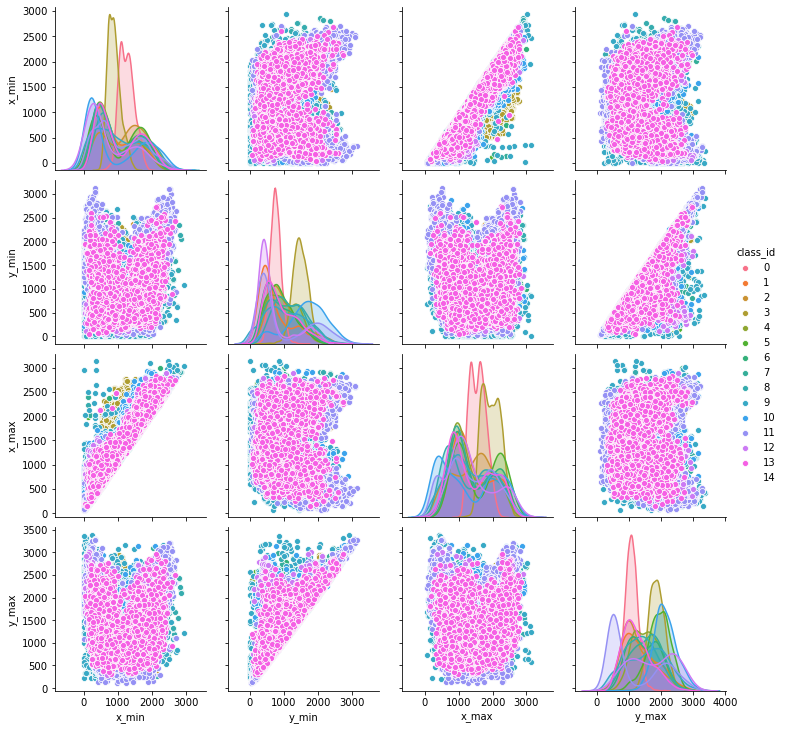

In [8]:
sns.pairplot(df, hue='class_id');

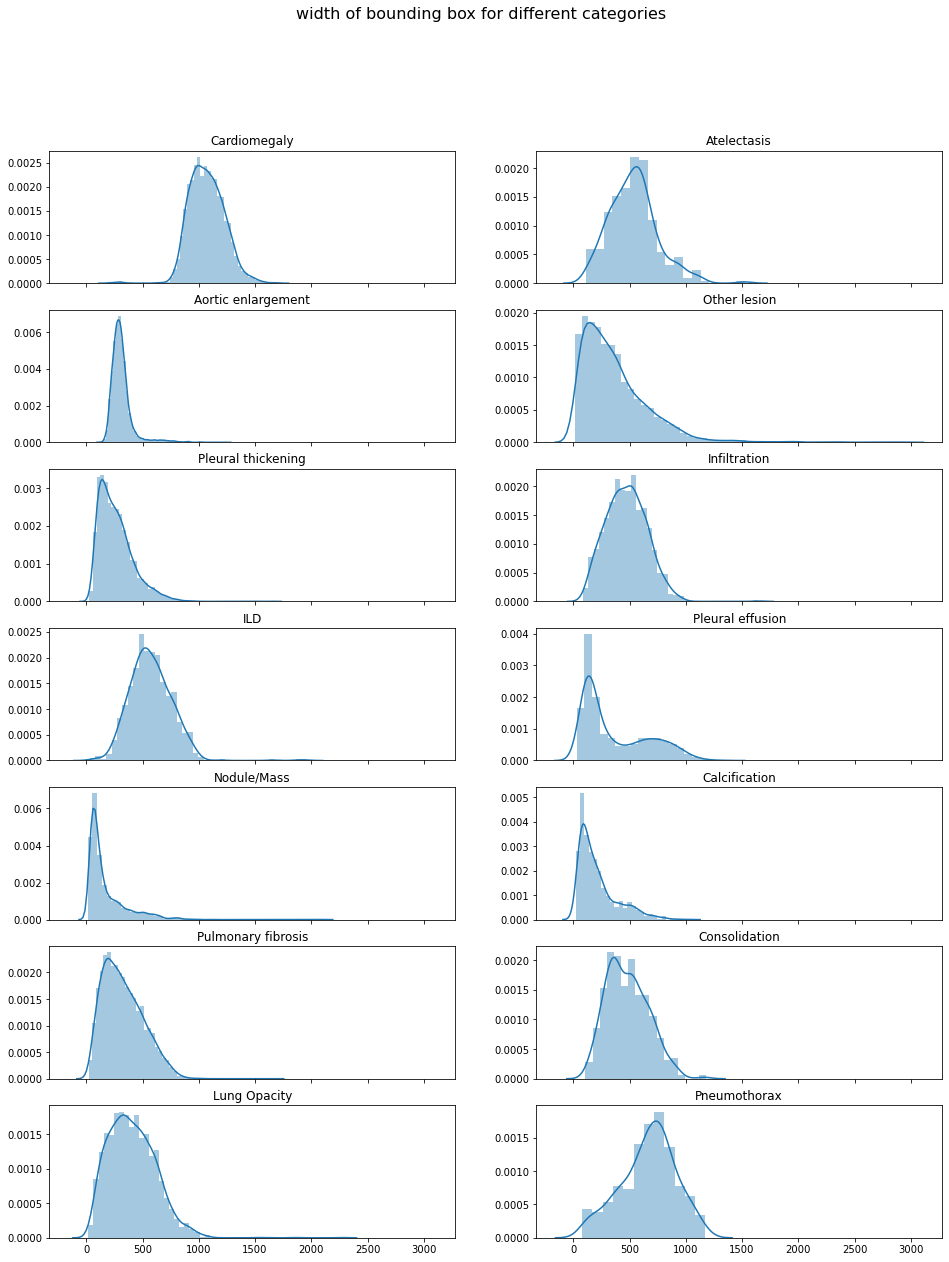

In [9]:
def plot_width_of__bounding_boxes(data):
    
    fig, axes = plt.subplots(7, 2, figsize=(16,20), sharex=True)
    fig.suptitle("width of bounding box for different categories", fontsize=16)
    
    classes = data.class_name.unique()
    for j, i in enumerate(classes[~np.isin(classes, 'No finding')]):
        data_ = data[data['class_name']==i]
        sns.distplot(data_['x_max'] - data_['x_min'], ax=axes[j%7, j//7]);
        axes[j%7, j//7].title.set_text(i);
    plt.show()

plot_width_of__bounding_boxes(df)

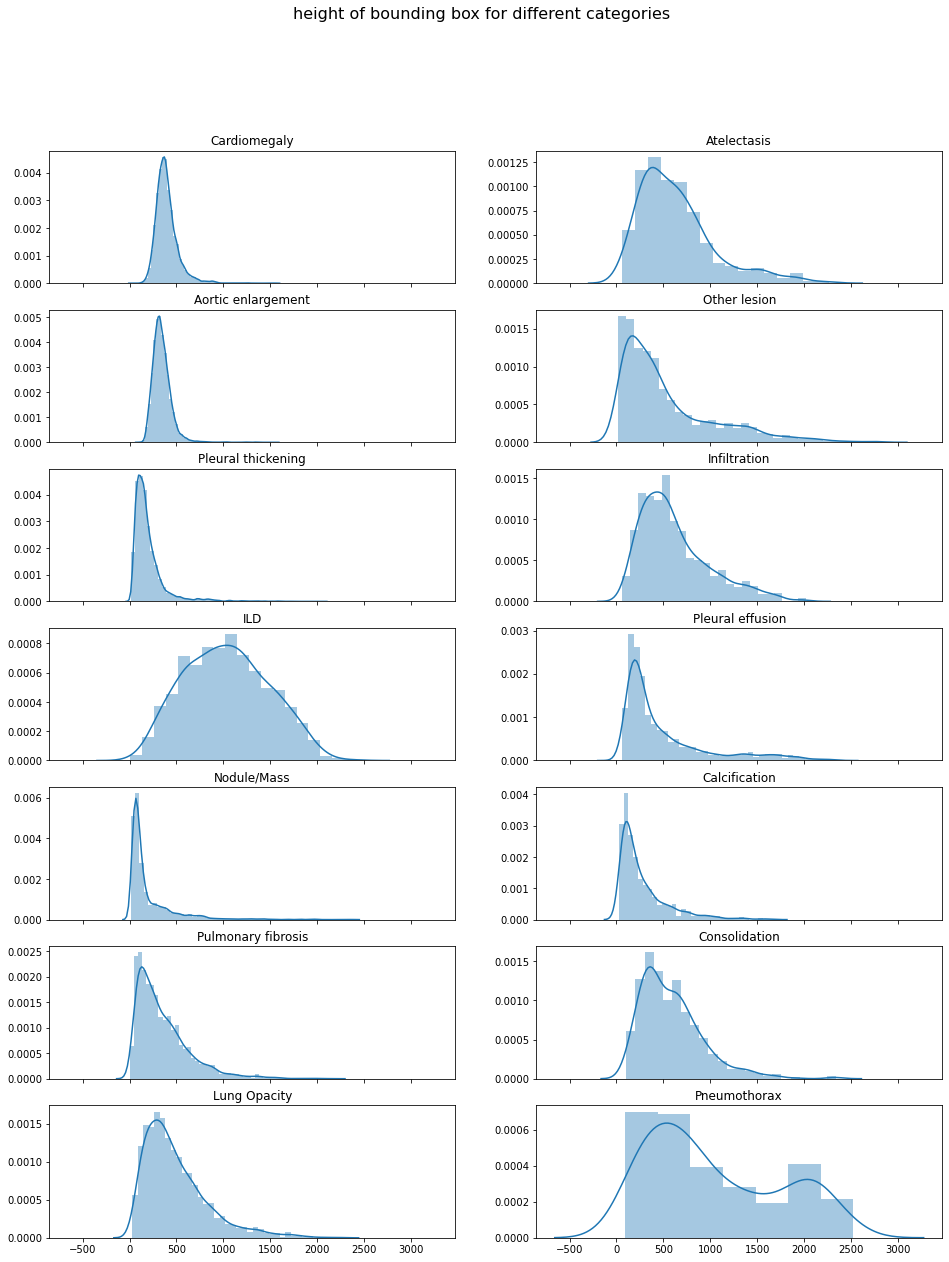

In [10]:
def plot_height_of_bounding_boxes(data):
    
    fig, axes = plt.subplots(7, 2, figsize=(16,20), sharex=True)
    fig.suptitle("height of bounding box for different categories", fontsize=16)
    
    classes = data.class_name.unique()
    for j, i in enumerate(classes[~np.isin(classes, 'No finding')]):
        data_ = data[data['class_name']==i]
        sns.distplot(data_['y_max'] - data_['y_min'], ax=axes[j%7, j//7]);
        axes[j%7, j//7].title.set_text(i);
    plt.show()

plot_height_of_bounding_boxes(df)

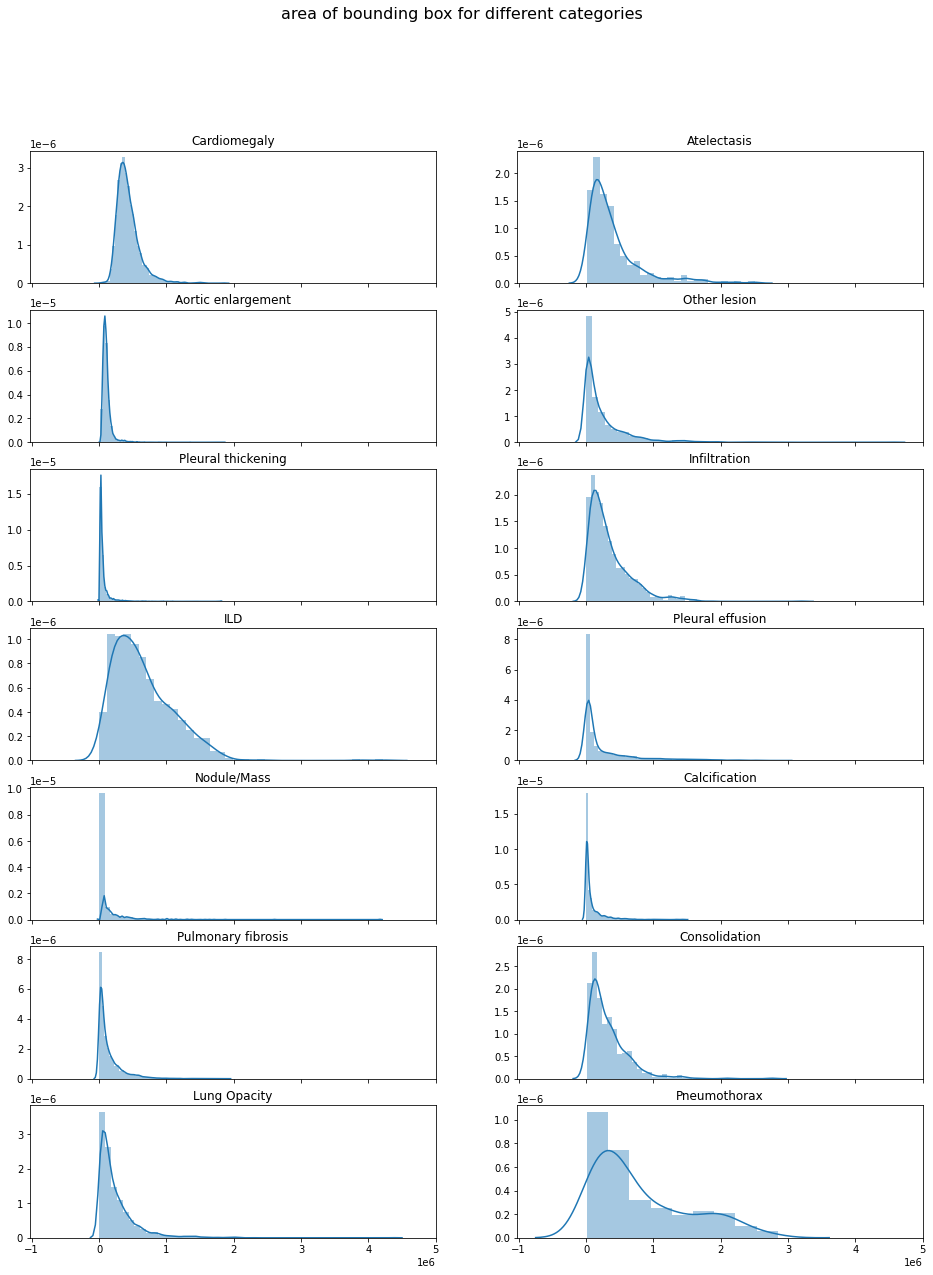

In [11]:
def plot_area_of_bounding_boxes(data):
    
    fig, axes = plt.subplots(7, 2, figsize=(16,20), sharex=True)
    fig.suptitle("area of bounding box for different categories", fontsize=16)
    
    classes = data.class_name.unique()
    for j, i in enumerate(classes[~np.isin(classes, 'No finding')]):
        data_ = data[data['class_name']==i]
        sns.distplot((data_['y_max'] - data_['y_min'])*(data_['x_max'] - data_['x_min']), 
                     ax=axes[j%7, j//7]);
        axes[j%7, j//7].title.set_text(i);
    plt.show()

plot_area_of_bounding_boxes(df)

# 3. 이미지 데이터 시각화

In [12]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    """ Convert dicom file to numpy array 
    
    Args:
        path (str): Path to the dicom file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply monochrome fix
        
    Returns:
        Numpy array of the respective dicom file 
        
    """
    dicom = pydicom.read_file(path)      # Use the pydicom library to read the dicom file
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning:

The (0028,0101) 'Bits Stored' value (14-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value



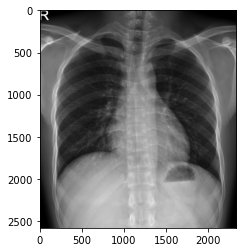

In [13]:
root = '/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/'
ext = '.dicom'

data = read_xray(root + df.image_id[0] + ext)
plt.imshow(data, 'gray');

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning:

The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value



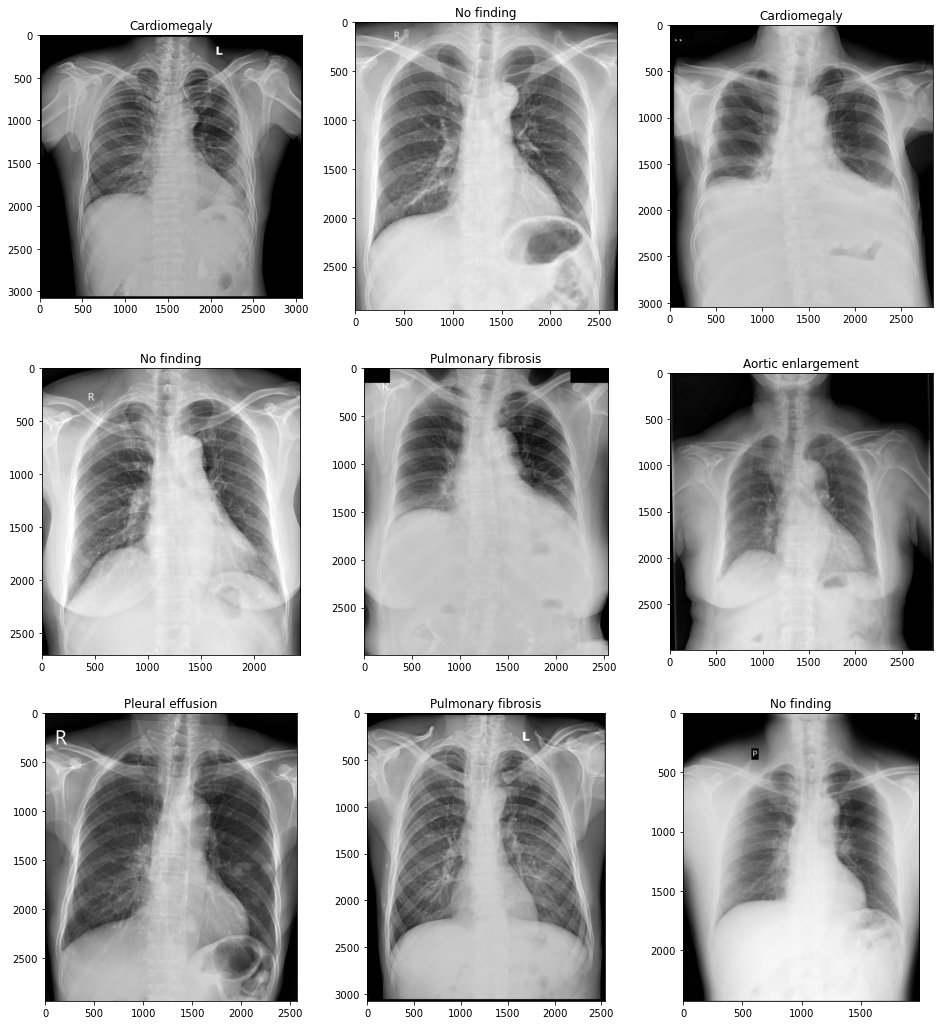

In [14]:
def show_xray(data, root=root, ext=ext):
    fig, axs = plt.subplots(3,3, figsize=(16,18))
    
    for i in range(9):
        k = np.random.randint(0,len(data))  #selecting random integer for plotting XRAY
        img_id = data.image_id[k]
        class_name = data.class_name[k]
        
        img_path = os.path.join(root, img_id+ext)
        dicom_pixel = read_xray(img_path)
        
        axs[i//3,i%3].imshow(dicom_pixel, cmap='gray')
        axs[i//3,i%3].title.set_text(class_name)
    plt.show()

show_xray(df)

## 3.1 anchor box 그리기

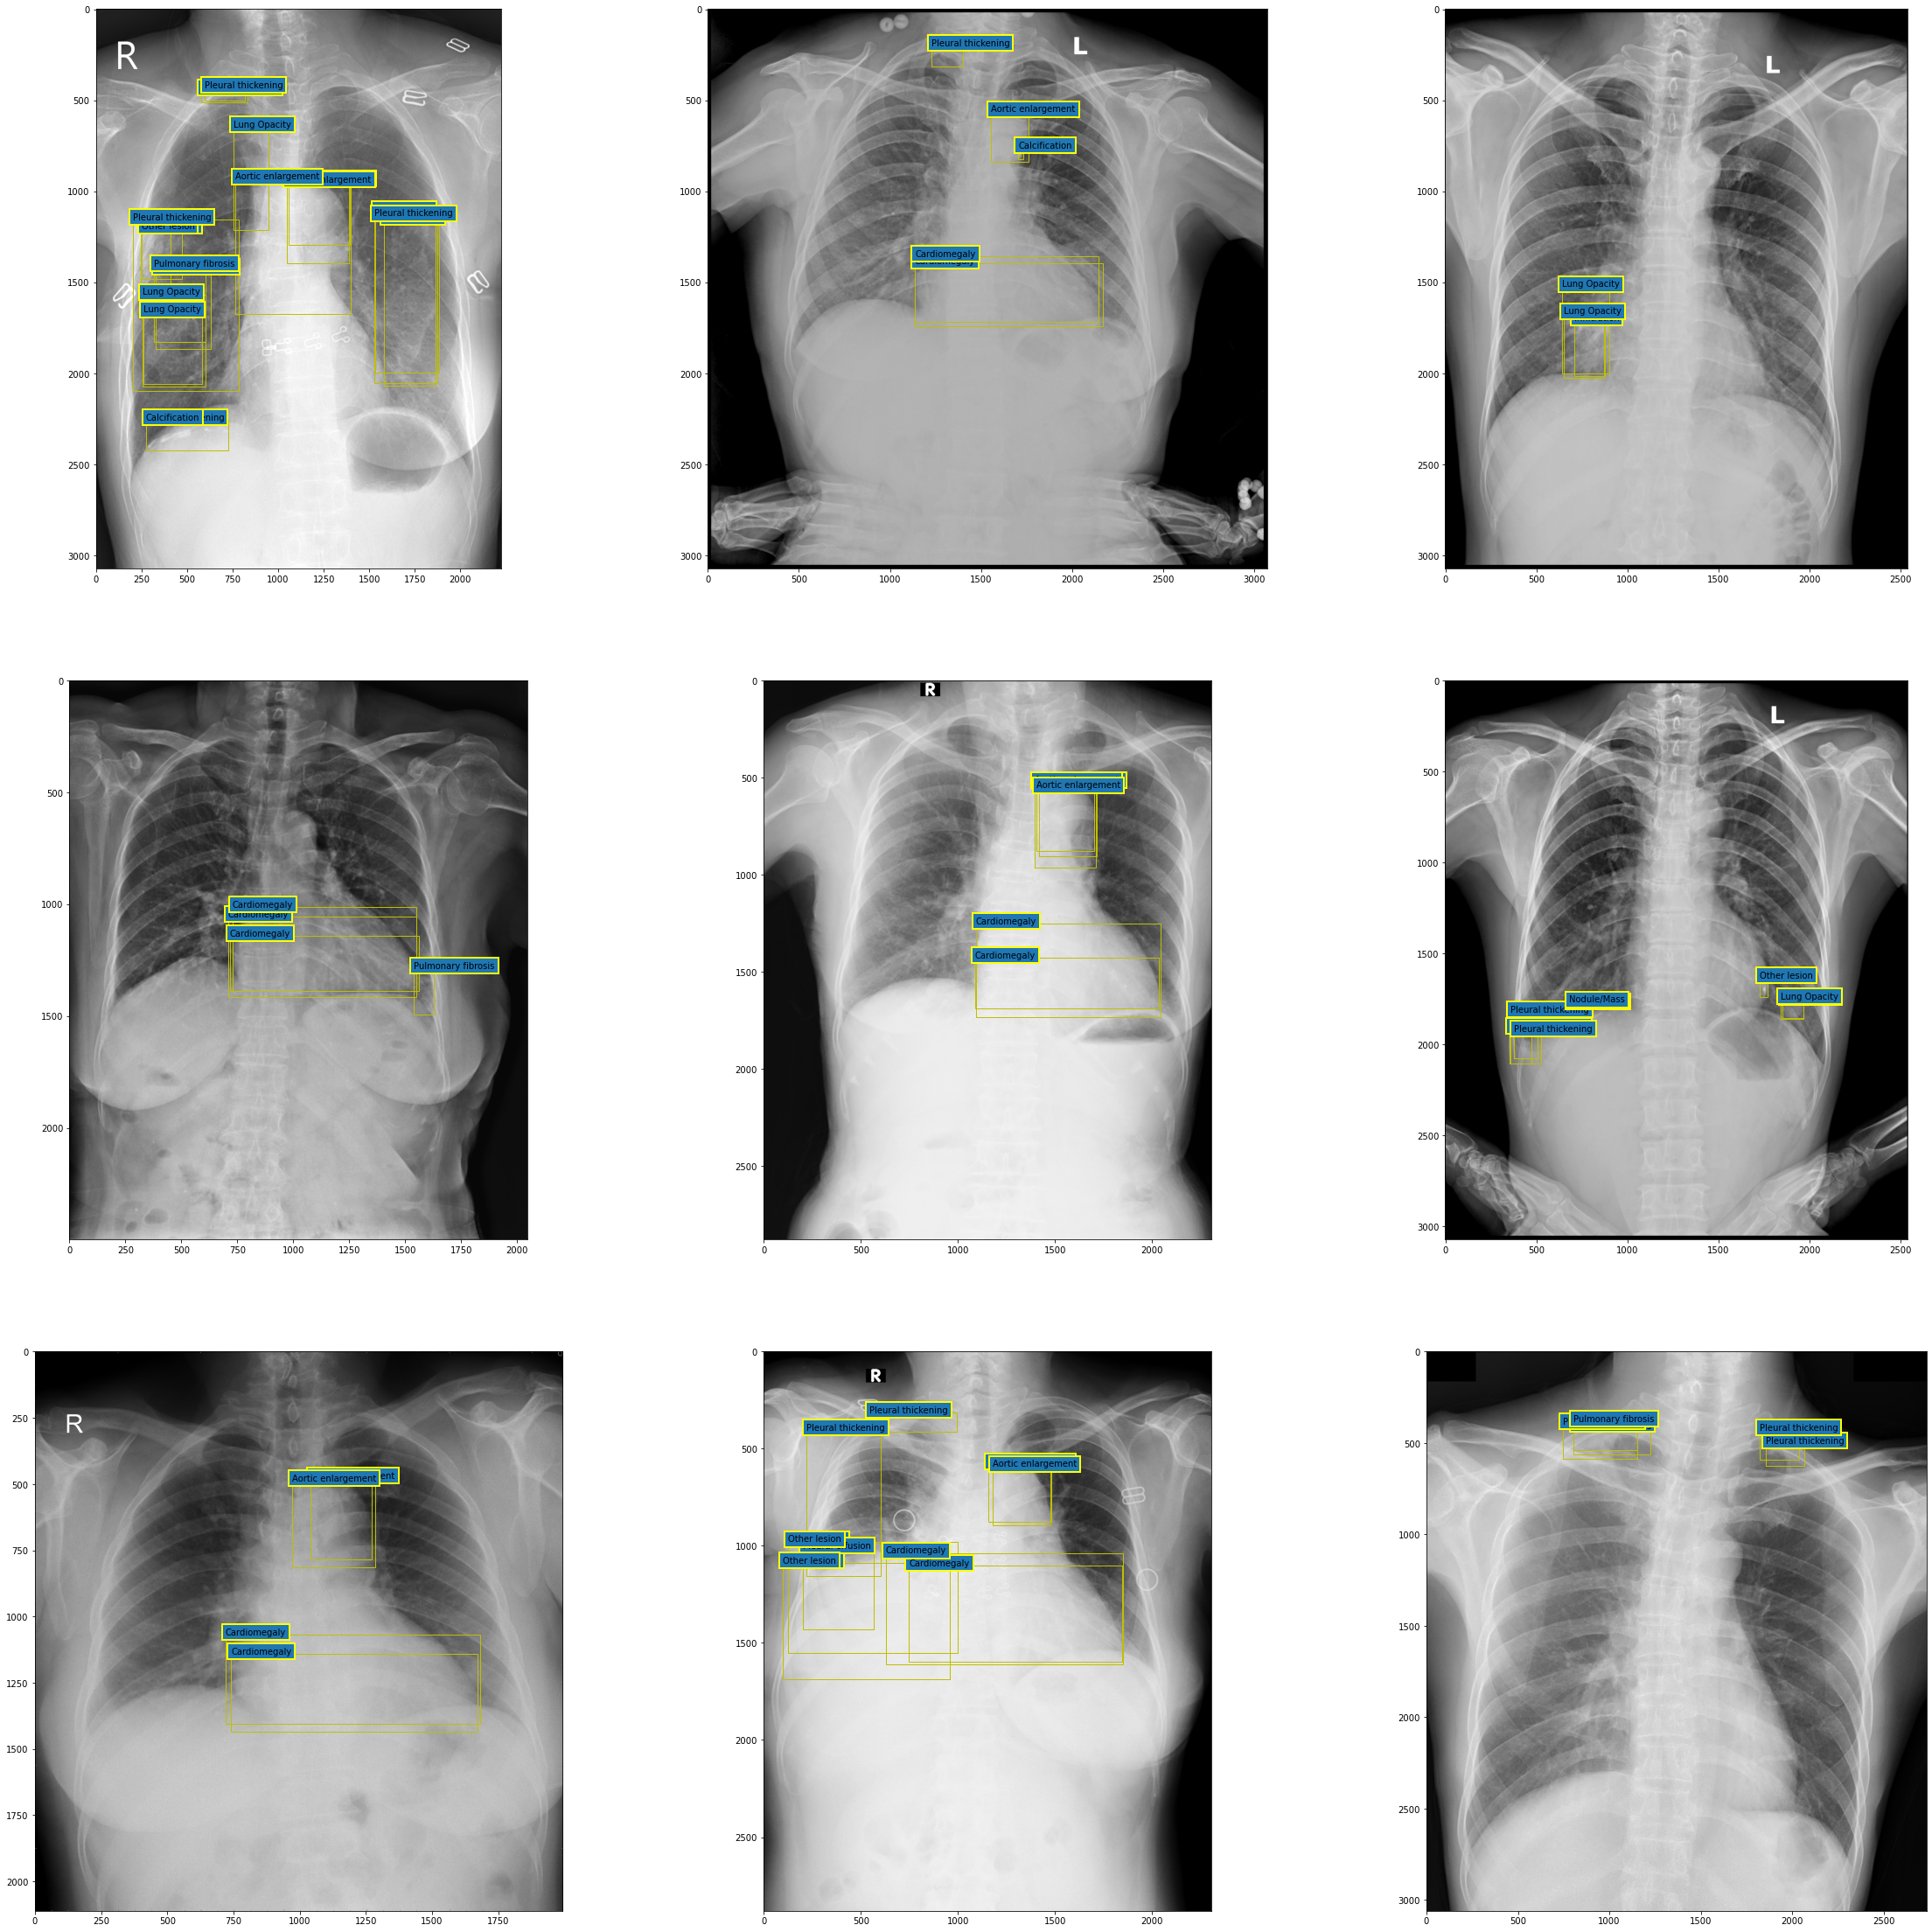

In [15]:
def show_xray_withAnchorBoxs(data, root=root, ext=ext, n=3):
    fig, axs = plt.subplots(n,n, figsize=(40,40))

    un_xrays = data.image_id.unique()
    for i in range(n*n):
        k = np.random.randint(0,len(un_xrays))  #selecting random integer for plotting XRAY
        xray_id = un_xrays[k] #taking xray name (image_id)
        
        abnorm_df = data[data.image_id==xray_id] #this df contains all anchor boxes loaction for a particula image_id
        abnorm_df.reset_index(drop=True, inplace=True) #reseting index
   
        xray_path = os.path.join(root, xray_id+ext) #path of that image
        img = read_xray(xray_path) #reading dicom file
        
        axs[i//n,i%n].imshow(img, cmap='gray')#plotting the image
        
        for j in range(len(abnorm_df)):

            axs[i//n,i%n].add_patch(patches.Rectangle(
                (abnorm_df['x_min'][j], abnorm_df['y_min'][j]), 
                abnorm_df['x_max'][j] - abnorm_df['x_min'][j], 
                abnorm_df['y_max'][j] - abnorm_df['y_min'][j], 
                edgecolor='y',
                linewidth=1,
                fill=False)
            )
            axs[i//n,i%n].text(
                abnorm_df['x_min'][j], abnorm_df['y_min'][j], #coordinate
                abnorm_df.class_name[j],  #sting 
                bbox=dict(fill=True, edgecolor='yellow', linewidth=2)
            )
    plt.show()

show_xray_withAnchorBoxs(df[df.class_name!='No finding']) #filtering no finding images

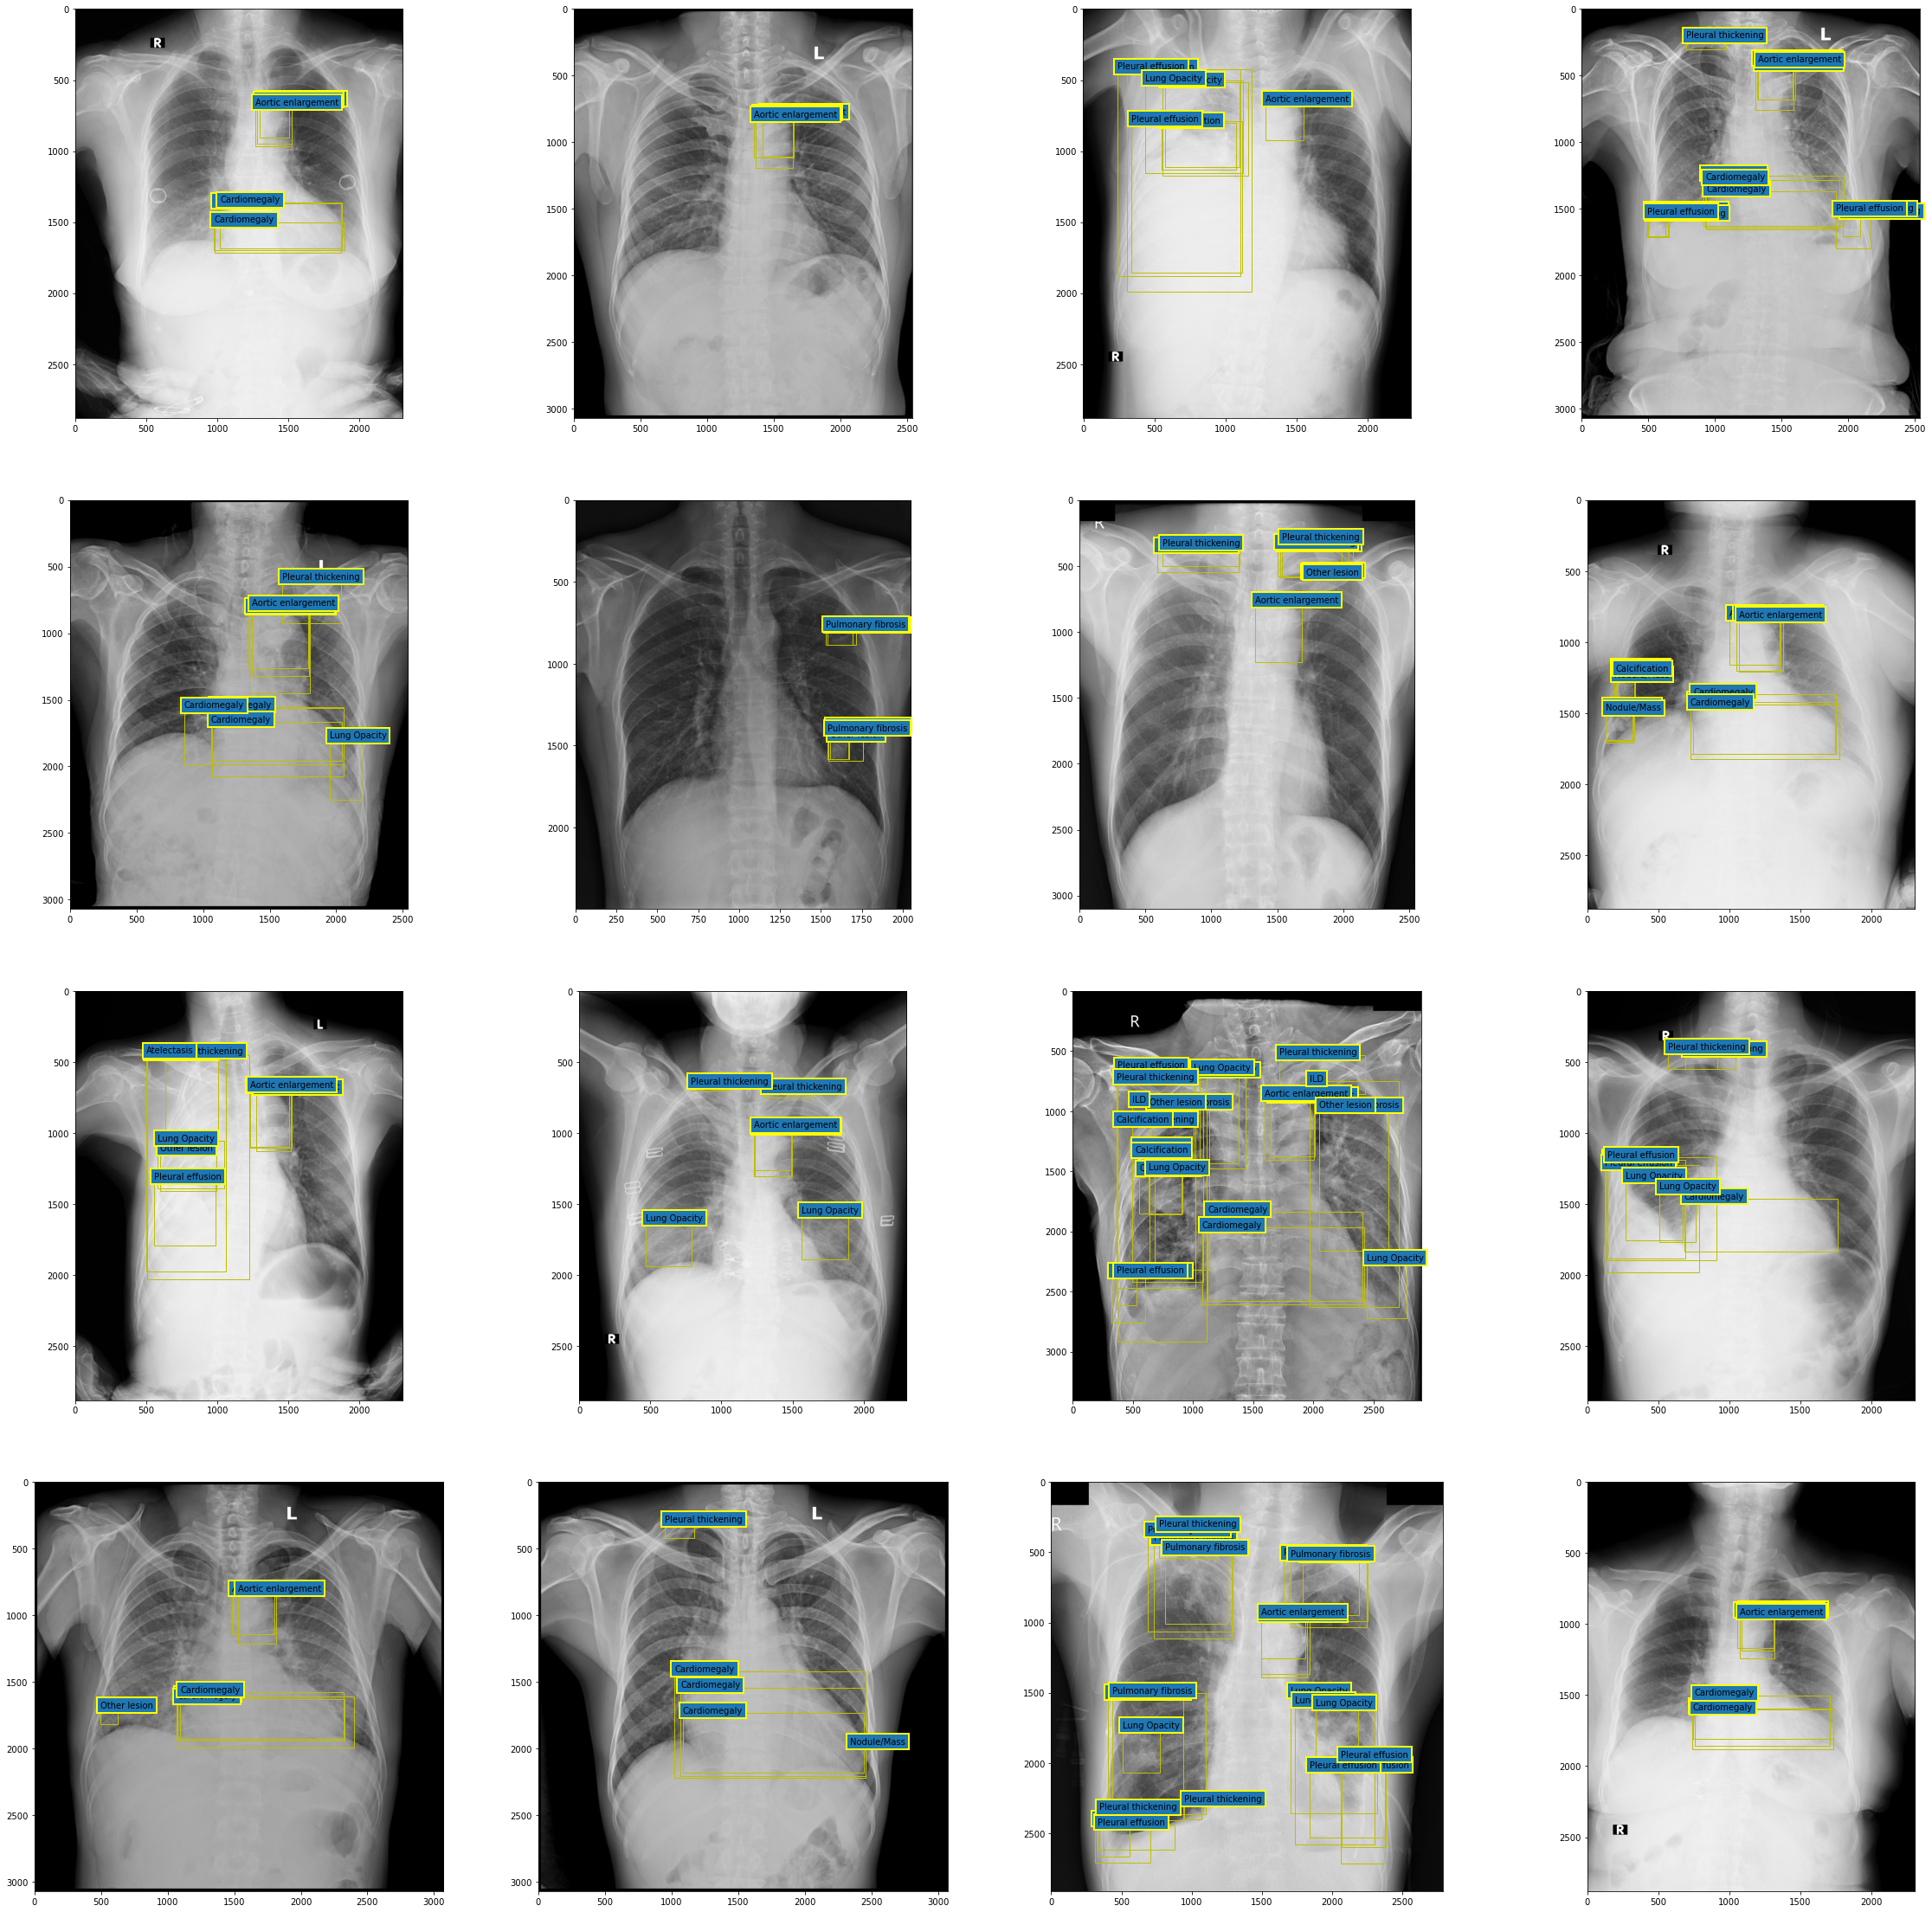

In [16]:
show_xray_withAnchorBoxs(df[df.class_name!='No finding'], n=4)

## 3.2 Generating Heatmaps

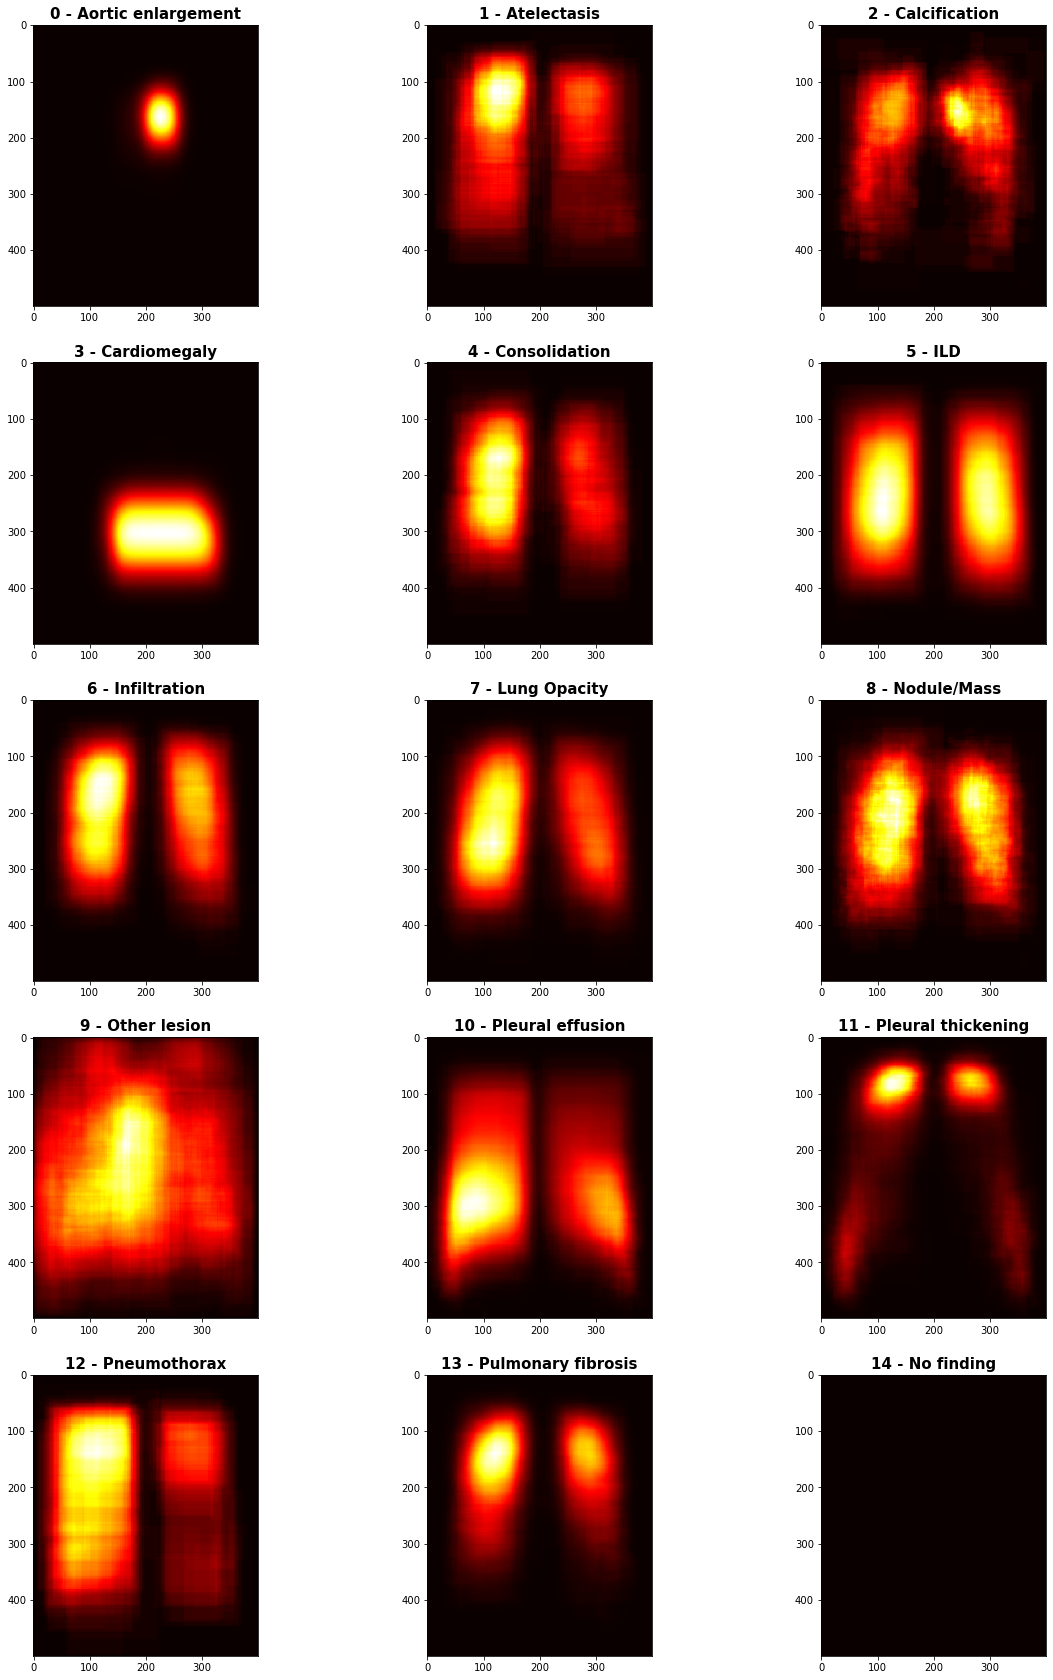

In [17]:
# courtsy of https://www.kaggle.com/craigmthomas/localization-of-findings

def add_image_dimensions_gender(df):
    path_spec = "../input/vinbigdata-chest-xray-abnormalities-detection/train/{}.dicom"
    height = []
    width = []
    gender = []
    age = []
    for _, row in df.iterrows():
        dcm = dcmread(Path(path_spec.format(row["image_id"])), stop_before_pixels=True)
        height.append(dcm.Rows)
        width.append(dcm.Columns)
        gender.append(dcm[0x10, 0x40].value)
        patient_age = dcm[0x10, 0x1010].value if [0x10, 0x1010] in dcm else ""
        age.append(patient_age)
    df["image_height"] = height
    df["image_width"] = width
    df["gender"] = gender
    df["age"] = age
    
    return df

def scale_bounding_boxes(df):
    df["x_min_norm"] = df["x_min"] / df["image_width"]
    df["y_min_norm"] = df["y_min"] / df["image_height"]
    df["x_max_norm"] = df["x_max"] / df["image_width"]
    df["y_max_norm"] = df["y_max"] / df["image_height"]
    
    return df

def draw_box_on_array(row, np_array):
    xy = [
        int(row["x_min_norm"] * 400), 
        int(row["y_min_norm"] * 500),
        int(row["x_max_norm"] * 400),
        int(row["y_max_norm"] * 500),
    ]
    np_array[xy[1]:xy[3], xy[0]:xy[2]] += 1
    
def get_bbox(df, class_id):
    np_array = np.zeros(shape=(500, 400))
    if class_id == 14:
        return np_array
    for _, row in df[df["class_id"] == class_id].iterrows():
        draw_box_on_array(row, np_array)
    return np_array

def plot_heatmap(data=df):
    data = add_image_dimensions_gender(data)
    data = scale_bounding_boxes(data)
    
    classes = [
        "0 - Aortic enlargement",
        "1 - Atelectasis",
        "2 - Calcification",
        "3 - Cardiomegaly", 
        "4 - Consolidation",
        "5 - ILD",
        "6 - Infiltration",
        "7 - Lung Opacity",
        "8 - Nodule/Mass",
        "9 - Other lesion",
        "10 - Pleural effusion",
        "11 - Pleural thickening",
        "12 - Pneumothorax",
        "13 - Pulmonary fibrosis",
        "14 - No finding",
    ]

    fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(get_bbox(df, i), cmap='hot', interpolation='nearest')
        _ = ax.set_title(classes[i], fontweight="bold", size=15)
        
plot_heatmap()